In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import networkx as nx

from causalnex.structure.pytorch import from_pandas
from causalnex.structure import StructureModel
from causalnex.network import BayesianNetwork
from causalnex.evaluation import classification_report, roc_auc
from causalnex.inference import InferenceEngine


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

import optuna

import warnings
warnings.simplefilter('ignore')

# データ読み込みから前処理

In [134]:
df = pd.read_excel('../data/231010-20_AI用qPCRデータ.xlsx', index_col=0, header=1)
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,...,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
0,0.000004,2.982088e-05,0.000004,1.512045e-05,0.000015,9.403729e-07,0.000122,0.000015,4.792578e-07,0.000007,...,0.000008,0.000121,1.193258e-07,0.000119,0.000004,0.000008,0.000015,0.000030,0.000015,0.000030
1,0.000008,3.062644e-05,0.000016,2.940716e-08,0.000015,3.847846e-06,0.000124,0.000015,3.848767e-06,0.000015,...,0.000015,0.000123,2.377373e-07,0.000123,0.000008,0.000016,0.000031,0.000061,0.000031,0.000061
2,0.000008,7.608227e-06,0.000016,1.396326e-08,0.000031,9.615077e-07,0.000245,0.000015,4.864569e-07,0.000031,...,0.000015,0.000122,9.666787e-07,0.000122,0.000008,0.000016,0.000062,0.000062,0.000031,0.000062
3,0.000004,1.513944e-05,0.000015,1.225795e-07,0.000015,4.807837e-07,0.000124,0.000015,1.207673e-07,0.000008,...,0.000015,0.000061,2.410427e-07,0.000061,0.000004,0.000008,0.000031,0.000062,0.000031,0.000062
4,0.000008,4.768491e-07,0.000031,6.105349e-08,0.000031,9.593193e-07,0.000124,0.000015,2.428970e-07,0.000016,...,0.000016,0.000124,4.795912e-07,0.000124,0.000008,0.000008,0.000031,0.000062,0.000031,0.000062


## 正規化

In [135]:
# Normalization
scaler = StandardScaler()
normalized_data_array = scaler.fit_transform(df)
# conversion array to Dataframe
normalized_df = pd.DataFrame(normalized_data_array, columns=df.columns)

# 偏相関係数

In [136]:
# # 偏相関行列の計算
# partial_corr_matrix = pg.pcorr(normalized_df).round(3)
# partial_corr_matrix

In [137]:
# # ヒートマップの描画
# plt.figure(figsize=(50, 25))
# sns.set(font_scale = 2)

# ax = sns.heatmap(
#             partial_corr_matrix, 
#             annot=True, 
#             fmt='g', 
#             cmap='Blues', 
#             annot_kws={"size":15}
#             )

# ax.xaxis.tick_top()
# ax.set_xticklabels(ax.get_xticklabels(), rotation=50)

# plt.savefig('./output/heatmap.png')

# パラメータ探索と構造学習

## ベイズ最適化関数

In [138]:
def objective(trial):
    # Optunaでチューニングするハイパーパラメータ
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    threshold = trial.suggest_float('threshold', 0.0, 1.0)
    lasso_beta = trial.suggest_float('lasso_beta', 1e-4, 1e-1, log=True)  # ログスケールでlassoの値を探索
    ridge_beta = trial.suggest_float('ridge_beta', 1e-4, 1e-1, log=True)  # リッジ正則化の係数を探索
    use_bias = trial.suggest_categorical('use_bias', [True, False])

    # StructureModelのインスタンスを作成
    sm = StructureModel()

    # NOTEARSアルゴリズムを用いて構造学習を実施
    # ここでfrom_pandasのパラメータをOptunaのtrialを通してチューニング
    sm, loss_value = from_pandas(normalized_df, 
                                 max_iter=max_iter,
                                 w_threshold=threshold,
                                 lasso_beta=lasso_beta,
                                 ridge_beta=ridge_beta,
                                 use_bias=use_bias,
                                 )

    # 学習された構造のスコアを計算（スコアリング方法はプロジェクトにより異なる）
    score = calculate_score(sm)

    return score

# スコアリング関数（例：エッジ数でスコアリング）
def calculate_score(sm):
    return -len(sm.edges)  # エッジの数が少ないほどスコアが高くなるように設定

## パラメタ調整

In [139]:
study = optuna.create_study(direction='maximize')  # スコアを最大化するように設定
study.optimize(objective, n_trials=100)  # 100回の試行で最適化

# 最適なハイパーパラメータを出力
print(study.best_params)

[I 2023-11-10 23:08:32,228] A new study created in memory with name: no-name-d22ac63a-986b-4c34-afd6-0007a0b3bcb3
[I 2023-11-10 23:08:46,892] Trial 0 finished with value: -89.0 and parameters: {'max_iter': 575, 'threshold': 0.5050373127605164, 'lasso_beta': 0.004754214917764361, 'ridge_beta': 0.00010275879552270771, 'use_bias': False}. Best is trial 0 with value: -89.0.
[I 2023-11-10 23:09:00,684] Trial 1 finished with value: -44.0 and parameters: {'max_iter': 798, 'threshold': 0.6933723155544157, 'lasso_beta': 0.003916269518546698, 'ridge_beta': 0.00017026631423634392, 'use_bias': True}. Best is trial 1 with value: -44.0.
[I 2023-11-10 23:09:14,880] Trial 2 finished with value: -63.0 and parameters: {'max_iter': 961, 'threshold': 0.6086827430922664, 'lasso_beta': 0.00043187042382631177, 'ridge_beta': 0.002146284902965062, 'use_bias': True}. Best is trial 1 with value: -44.0.
[I 2023-11-10 23:09:27,189] Trial 3 finished with value: -26.0 and parameters: {'max_iter': 445, 'threshold': 0

{'max_iter': 616, 'threshold': 0.9992559259924886, 'lasso_beta': 0.00014929258723191216, 'ridge_beta': 0.09979504625694516, 'use_bias': True}


In [140]:
# 最適パラメータ
study.best_params

{'max_iter': 616,
 'threshold': 0.9992559259924886,
 'lasso_beta': 0.00014929258723191216,
 'ridge_beta': 0.09979504625694516,
 'use_bias': True}

In [155]:
# cuda割り当て
import torch
torch.set_default_tensor_type('torch.cuda.FloatTensor')

# 最適な閾値を取得
best_max_iter = study.best_params['max_iter']
best_threshold = study.best_params['threshold']
my_driven_hidden_layer_units = [3] # 中間層
best_lasso_beta = study.best_params['lasso_beta']
best_ridge_beta = study.best_params['ridge_beta']
best_use_bias = study.best_params['use_bias']

# 最適な閾値で構造学習を実施
best_sm, loss_value = from_pandas(normalized_df,
                                  max_iter=best_max_iter,
                                  w_threshold=best_threshold,
                                  hidden_layer_units=my_driven_hidden_layer_units,
                                  lasso_beta=best_lasso_beta,
                                  ridge_beta=best_ridge_beta,
                                  use_bias=best_use_bias,
                                  )

best_sm.threshold_till_dag()

# 損失関数の出力
print("損失関数:", loss_value)
print("ノード:", best_sm.nodes)

損失関数: 0.8063527375925332
ノード: ['glk', 'agp', 'yihX', 'pgm', 'ptsG', 'malx', 'crr', 'galM', 'yihR', 'yeaD', 'pgi', 'ascF', 'chbF', 'ascB', 'bglA', 'bglB', 'yggF', 'glpX', 'fbp', 'pfkB', 'pfkA', 'fbaB', 'fbaA', 'tpiA', 'gapA', 'pgk', 'gpmA', 'ytjc', 'gpmM', 'eno', 'pykF', 'pykA', 'ppsA']


In [156]:
# エッジが伸びていないノードを排除, 関係性の強いエッジを太くする
edge_width = [d["weight"]*1 for (u, v, d) in best_sm.edges(data=True)]
# 上記の処置を施したものを新たなグラフとして保存
sm_l = best_sm.get_largest_subgraph()
print("構造モデル:", sm_l)

構造モデル: StructureModel with 13 nodes and 14 edges


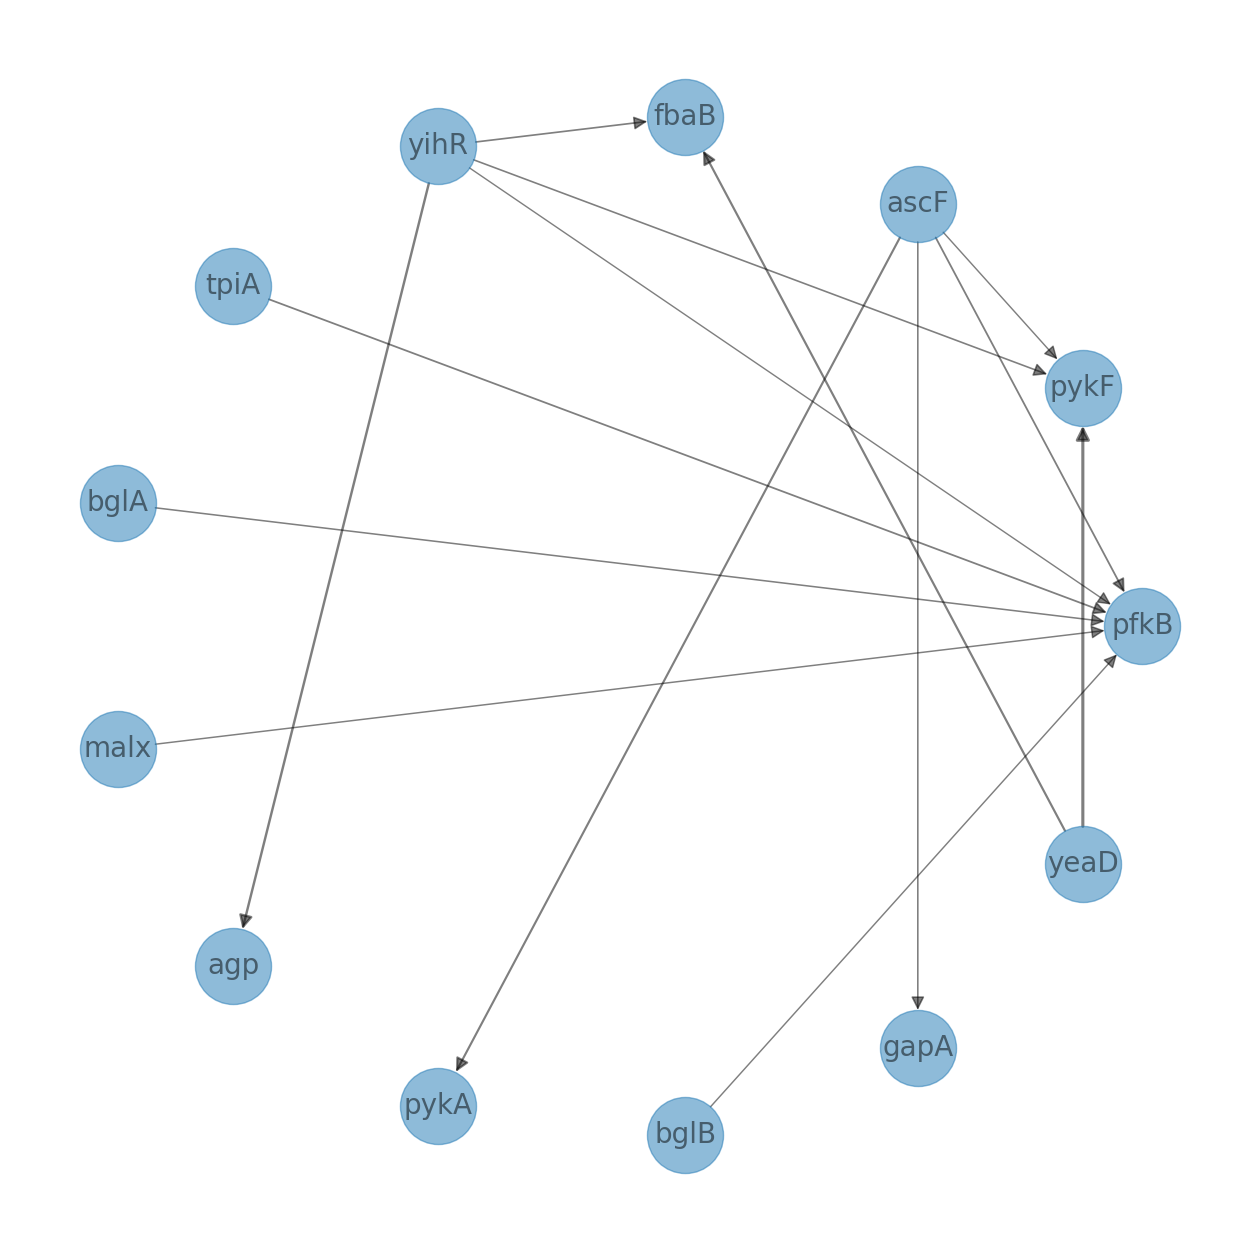

In [157]:
# ネットワーク図を描画
fig, ax = plt.subplots(figsize=(16,16))
nx.draw_circular(sm_l,
                 with_labels=True,
                 font_size=20,
                 node_size=3000,
                 arrowsize=20,
                 alpha=0.5,
                 width=edge_width,
                 ax=ax)

plt.savefig("./output/best_network.png", format="png", dpi=300)

# ベイジアンネットワーク

## 離散化処理

In [158]:
# Discretize the features
# Excluding the first column which seems to be an index or identifier
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
discretised_data = discretizer.fit_transform(normalized_df.iloc[:, :])

# Creating a new DataFrame for the discretized data
discretised_data = pd.DataFrame(discretised_data, columns=normalized_df.columns)

# Display the first few rows of the discretized data
discretised_data.head()

,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,...,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [176]:
# 構造モデルのノードの確認
nodes = list(sm_l.nodes)
print('nodes:', nodes)

nodes: ['pfkB', 'pykF', 'ascF', 'fbaB', 'yihR', 'tpiA', 'bglA', 'malx', 'agp', 'pykA', 'bglB', 'gapA', 'yeaD']


In [177]:
bn = BayesianNetwork(sm_l)
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1)
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train)

for i in range(len(nodes)):
    print(nodes[i])
    display(bn.cpds[nodes[i]])

pfkB


ascF  0.0                                               ...  1.0            \
bglA  0.0                                               ...  1.0             
bglB  0.0                                     1.0       ...  0.0       1.0   
malx  0.0                 1.0                 0.0       ...  1.0       0.0   
tpiA  0.0       1.0       0.0       1.0       0.0       ...  1.0       0.0   
yihR  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  ...  0.0  1.0  0.0   
pfkB                                                    ...                  
0.0   1.0  0.5  0.5  0.5  1.0  0.5  0.5  0.5  0.5  0.5  ...  0.5  0.5  0.5   
1.0   0.0  0.5  0.5  0.5  0.0  0.5  0.5  0.5  0.5  0.5  ...  0.5  0.5  0.5   

ascF                                     
bglA                                     
bglB                                     
malx                 1.0                 
tpiA       1.0       0.0       1.0       
yihR  1.0  0.0  1.0  0.0  1.0  0.0  1.0  
pfkB                                     
0.0   0.5  0.5  0.5  0.5  0.5  0.5  0.0  
1.0   0.5  0.5  0.5  0.5  0.5  0.5  1.0  

[2 rows x 64 columns]

pykF


ascF       0.0                 1.0               
yeaD       0.0       1.0       0.0       1.0     
yihR       0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0
pykF                                             
0.0   0.988166  0.5  1.0  0.5  0.5  0.5  0.5  0.0
1.0   0.011834  0.5  0.0  0.5  0.5  0.5  0.5  1.0

ascF


,
ascF,
0.0,0.994152
1.0,0.005848


fbaB


yeaD      0.0       1.0     
yihR      0.0  1.0  0.0  1.0
fbaB                        
0.0   0.95858  0.5  1.0  0.0
1.0   0.04142  0.5  0.0  1.0

yihR


,
yihR,
0.0,0.994152
1.0,0.005848


tpiA


,
tpiA,
0.0,0.994152
1.0,0.005848


bglA


,
bglA,
0.0,0.994152
1.0,0.005848


malx


,
malx,
0.0,0.988304
1.0,0.011696


agp


yihR,0.0,1.0
agp,,
0.0,1.0,0.0
1.0,0.0,1.0


pykA


ascF,0.0,1.0
pykA,,
0.0,1.0,0.0
1.0,0.0,1.0


bglB


,
bglB,
0.0,0.994152
1.0,0.005848


gapA


ascF,0.0,1.0
gapA,,
0.0,0.982353,0.0
1.0,0.017647,1.0


yeaD


,
yeaD,
0.0,0.988304
1.0,0.011696


# 評価

In [ ]:
# predictions = bn.predict(discretised_data, "pgi")
# print(discretised_data.loc[1, "pgi"])

In [ ]:
# display(classification_report(bn, test, "pgi"))

## 各変数のAUC

In [178]:
for n in bn.nodes:
    roc, auc = roc_auc(bn, test, n)
    print(n, auc)

ascF 1.0
pfkB 1.0
gapA 0.95
pykF 1.0
pykA 1.0
yihR 1.0
agp 1.0
fbaB 1.0
tpiA 1.0
bglA 1.0
malx 1.0
bglB 1.0
yeaD 1.0


## 条件付き確率の可視化

In [ ]:
# for i in range(len(nodes)):
#     node = nodes[i]
#     cpd = bn.cpds[node]
    
#     # CPDをDataFrameに変換（CausalNexのCPDオブジェクトがDataFrameに直接変換可能であると仮定）
#     cpd_df = pd.DataFrame(cpd)

#     # ヒートマップを描画
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cpd_df, annot=True, cmap='viridis')
#     plt.title(f'CPD of Node: {node}')
#     plt.ylabel('Parent states' if cpd_df.shape[0] > 1 else 'State')
#     plt.xlabel('Node states')
#     plt.show()


# 介入によるシミュレーション

In [230]:
# InferenceEngineを初期化
engine = InferenceEngine(bn)

# 介入を行うノードとその状態を選択
intervention_node = nodes[4]
intervention_state_0 = 0.0  # 離散化された状態の例
intervention_state_1 = 1.0  # 離散化された状態の例
num_0 = 0.0  # 発生しない確率
num_1 = 1.0  # 発生する確率

intervention_condition = f'intervention node: {intervention_node} \n 発生しない確率: {num_0}, 発生する確率: {num_1}'

print(f"介入前の{intervention_node}: ", engine.query())

# 介入を実行
engine.do_intervention(intervention_node, {intervention_state_0: num_0,
                                           intervention_state_1: num_1})

print(f"介入後の{intervention_node}: ", engine.query())

# 介入後の確率分布を確認
marginals_after_intervention = engine.query()


介入前のyihR:  {'ascF': {0.0: 0.9941520467836251, 1.0: 0.005847953216374268}, 'pfkB': {0.0: 0.9855501127057605, 1.0: 0.01444988729423943}, 'gapA': {0.0: 0.9766081871345024, 1.0: 0.023391812865497068}, 'pykF': {0.0: 0.9826094338818897, 1.0: 0.01739056611810981}, 'pykA': {0.0: 0.9941520467836251, 1.0: 0.005847953216374268}, 'yihR': {0.0: 0.9941520467836252, 1.0: 0.005847953216374266}, 'agp': {0.0: 0.9941520467836252, 1.0: 0.005847953216374266}, 'fbaB': {0.0: 0.956345542218118, 1.0: 0.04365445778188159}, 'tpiA': {0.0: 0.9941520467836251, 1.0: 0.0058479532163742765}, 'bglA': {0.0: 0.9941520467836251, 1.0: 0.0058479532163742765}, 'malx': {0.0: 0.9883040935672511, 1.0: 0.01169590643274854}, 'bglB': {0.0: 0.9941520467836251, 1.0: 0.005847953216374277}, 'yeaD': {0.0: 0.988304093567251, 1.0: 0.011695906432748529}}
介入後のyihR:  {'ascF': {0.0: 0.9941520467836253, 1.0: 0.005847953216374268}, 'pfkB': {0.0: 0.4999999999931604, 1.0: 0.5000000000068393}, 'gapA': {0.0: 0.9766081871345026, 1.0: 0.023391812865

yihR介入後のpfkBの周辺分布: {0.0: 0.4999999999931604, 1.0: 0.5000000000068393}
yihR介入後のpykFの周辺分布: {0.0: 0.4999658014431789, 1.0: 0.5000341985568207}
yihR介入後のascFの周辺分布: {0.0: 0.9941520467836253, 1.0: 0.005847953216374268}
yihR介入後のfbaBの周辺分布: {0.0: 0.49415204678362556, 1.0: 0.5058479532163741}
yihR介入後のyihRの周辺分布: {0.0: 0.0, 1.0: 0.9999999999999997}
yihR介入後のtpiAの周辺分布: {0.0: 0.994152046783625, 1.0: 0.005847953216374276}
yihR介入後のbglAの周辺分布: {0.0: 0.994152046783625, 1.0: 0.005847953216374275}
yihR介入後のmalxの周辺分布: {0.0: 0.9883040935672512, 1.0: 0.011695906432748529}
yihR介入後のagpの周辺分布: {0.0: 0.0, 1.0: 0.9999999999999997}
yihR介入後のpykAの周辺分布: {0.0: 0.9941520467836253, 1.0: 0.005847953216374268}
yihR介入後のbglBの周辺分布: {0.0: 0.994152046783625, 1.0: 0.0058479532163742765}
yihR介入後のgapAの周辺分布: {0.0: 0.9766081871345026, 1.0: 0.02339181286549707}
yihR介入後のyeaDの周辺分布: {0.0: 0.9883040935672511, 1.0: 0.011695906432748534}


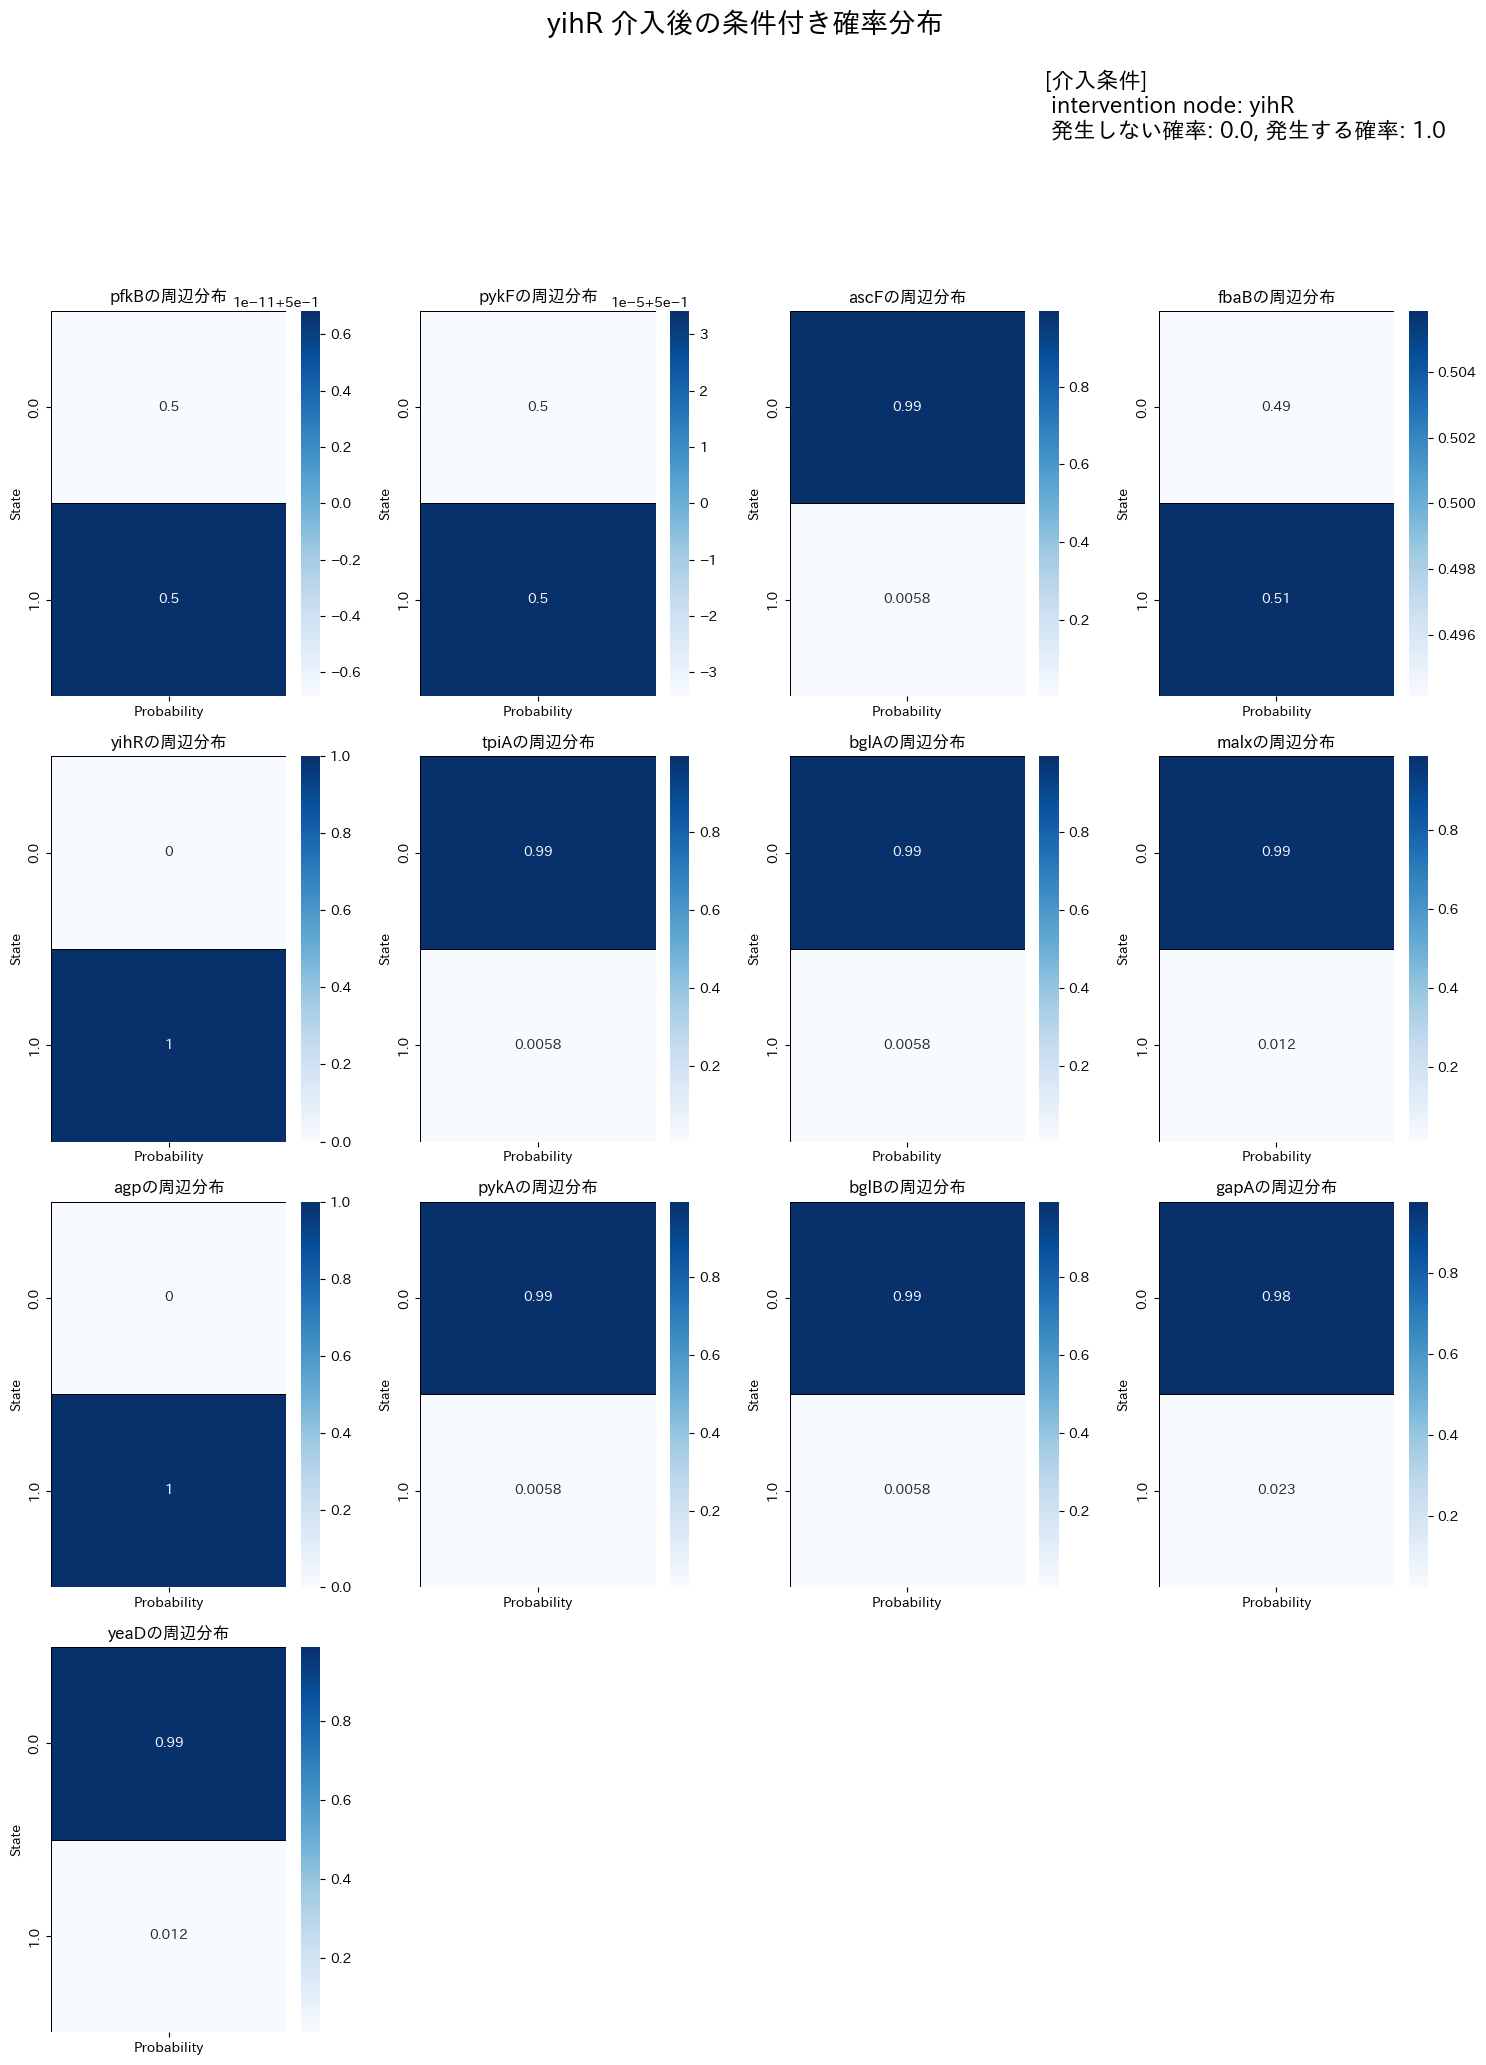

In [231]:
# 結果を表示
for node in nodes:
    print(f"{intervention_node}介入後の{node}の周辺分布: {marginals_after_intervention[node]}")

# ノードの数に基づいてサブプロットの行と列の数を決定
num_nodes = len(nodes)
cols = 4  # 1行に表示するヒートマップの数
rows = num_nodes // cols + (num_nodes % cols > 0)

# サブプロットを作成
fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))
plt.suptitle(f'{intervention_node} 介入後の条件付き確率分布', y=1.03, fontsize=20)
# 介入の条件を表示
plt.figtext(0.7, 1.0, f'[介入条件] \n {intervention_condition}', ha='left', va='top', fontsize=16)

for i, node in enumerate(nodes):
    cpd_dict = engine.query()[node]
    cpd_df = pd.DataFrame(list(cpd_dict.items()), columns=['State', 'Probability'])

    # 現在のサブプロットを取得
    ax = axs[i // cols, i % cols] if rows > 1 else axs[i]

    # ヒートマップを描画
    sns.heatmap(cpd_df.set_index('State'), annot=True, cmap='Blues', linecolor='black', linewidths=0.5, ax=ax)
    ax.set_title(f'{node}の周辺分布')
    ax.set_xlabel('')
    ax.set_ylabel('State')

# 空のサブプロットを非表示にする
for i in range(num_nodes, rows * cols):
    axs[i // cols, i % cols].axis('off')

# レイアウトを調整
plt.tight_layout(rect=[0, 0, 1, 0.92])  # rectパラメータで上部の空間を確保
plt.savefig(f"./output/{intervention_node}_CPD_heatmap.png", format="png", dpi=300, bbox_inches='tight')
plt.show()